In [17]:
# Install required packages
import sys
import subprocess

def install_packages():
    packages = ['pandas', 'numpy', 'matplotlib', 'seaborn', 'statsmodels', 'scikit-learn']
    for package in packages:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])
    print("All packages installed successfully!")
    print("Please restart the kernel and run all cells")

install_packages()

All packages installed successfully!
Please restart the kernel and run all cells


In [27]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

In [28]:
# Load and preprocess data
try:
    df = pd.read_csv(r"F:\Git\Internship\dataset\train.csv")
    
    # Convert date with UK format (DD/MM/YYYY)
    df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')
    df = df.sort_values('Order Date')
    df = df.set_index('Order Date')
    
    # Aggregate daily sales
    daily_sales = df.resample('D')['Sales'].sum()
    daily_sales = daily_sales.asfreq('D').fillna(0)
    
    print("Data preprocessed successfully!")
    print(f"Date range: {daily_sales.index.min()} to {daily_sales.index.max()}")
    print(f"Total days: {len(daily_sales)}")
except Exception as e:
    print(f"Error in data preprocessing: {e}")
    print("\nFirst few dates in the dataset:")
    print(df['Order Date'].head())

Data preprocessed successfully!
Date range: 2015-01-03 00:00:00 to 2018-12-30 00:00:00
Total days: 1458


In [29]:
# Check stationarity and prepare data
try:
    # ADF Test
    result = adfuller(daily_sales)
    print("Stationarity Test Results:")
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    
    # Apply differencing if needed
    if result[1] > 0.05:
        print("\nData is not stationary, applying differencing...")
        daily_sales_diff = daily_sales.diff().dropna()
    else:
        print("\nData is stationary")
        daily_sales_diff = daily_sales
    
    # Train-test split
    train = daily_sales_diff[:-30]
    test = daily_sales_diff[-30:]
    
    print("\nTrain-test split complete")
    print(f"Training set size: {len(train)}")
    print(f"Test set size: {len(test)}")
except Exception as e:
    print(f"Error in stationarity check: {e}")

Stationarity Test Results:
ADF Statistic: -4.926583375196242
p-value: 3.094891245873544e-05

Data is stationary

Train-test split complete
Training set size: 1428
Test set size: 30


In [30]:
# Train SARIMA model and make predictions
try:
    # Train model on original data (not differenced)
    model = SARIMAX(daily_sales, order=(1,1,1), seasonal_order=(1,1,1,7))
    sarima_fit = model.fit(disp=False)
    
    # Make predictions
    # Get predictions for test period
    test_predictions = sarima_fit.get_forecast(steps=30)
    pred_mean = test_predictions.predicted_mean
    
    # Forecast next 30 days
    forecast = sarima_fit.get_forecast(steps=30)
    forecast_index = pd.date_range(start=daily_sales.index[-1] + pd.Timedelta(days=1), periods=30)
    forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)
    
    # Get confidence intervals
    pred_ci = test_predictions.conf_int()
    
    print("Model training and forecasting complete!")
    print(f"\nForecast mean for first 5 days:\n{forecast_series.head()}")
except Exception as e:
    print(f"Error in model training/forecasting: {e}")

Model training and forecasting complete!

Forecast mean for first 5 days:
2018-12-31    3382.169332
2019-01-01    3310.411070
2019-01-02    1782.185474
2019-01-03    1117.712666
2019-01-04    3164.915544
Freq: D, Name: predicted_mean, dtype: float64


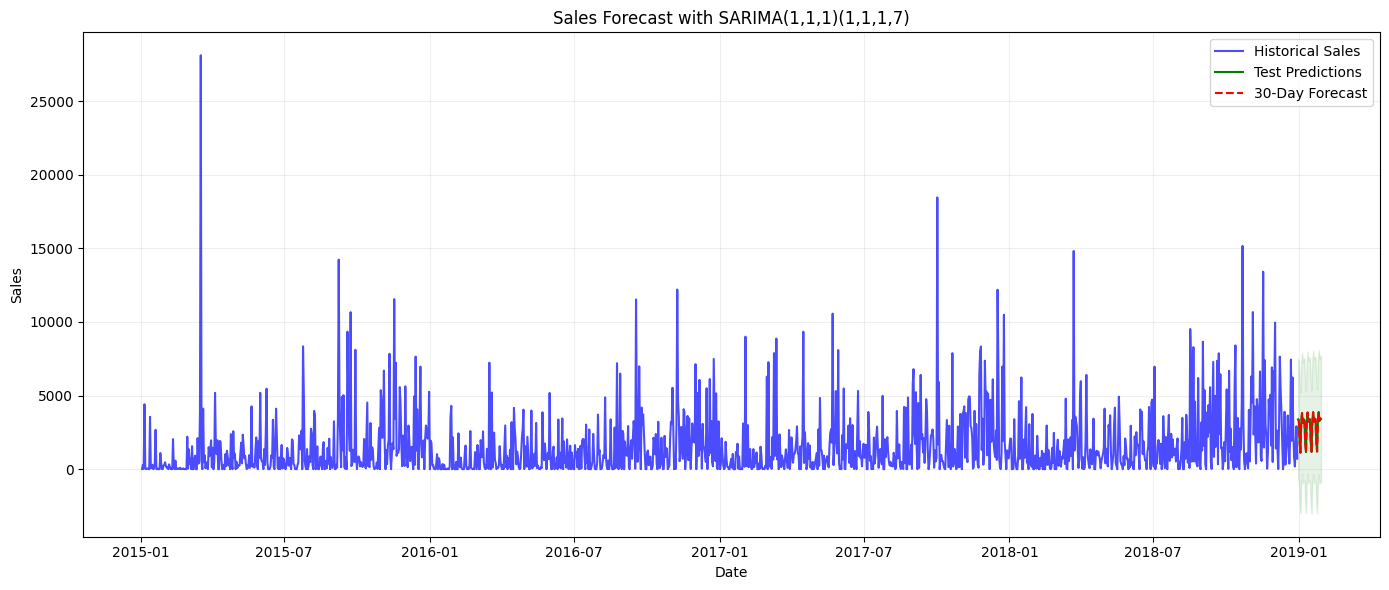


Next 30 Days Forecast Summary:
Average forecasted daily sales: £2899.75
Maximum forecasted daily sales: £3884.38
Minimum forecasted daily sales: £1117.71


In [31]:
# Visualize results with confidence intervals
try:
    plt.figure(figsize=(14,6))
    
    # Plot historical data
    plt.plot(daily_sales, label='Historical Sales', color='blue', alpha=0.7)
    
    # Plot test predictions with confidence intervals
    plt.plot(pred_mean, label='Test Predictions', color='green')
    plt.fill_between(pred_ci.index, 
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='g', alpha=.1)
    
    # Plot forecast
    plt.plot(forecast_series.index, forecast_series, 
             label='30-Day Forecast', color='red', linestyle='--')
    
    plt.title('Sales Forecast with SARIMA(1,1,1)(1,1,1,7)')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

    print("\nNext 30 Days Forecast Summary:")
    print(f"Average forecasted daily sales: £{forecast_series.mean():.2f}")
    print(f"Maximum forecasted daily sales: £{forecast_series.max():.2f}")
    print(f"Minimum forecasted daily sales: £{forecast_series.min():.2f}")
except Exception as e:
    print(f"Error in visualization: {e}")